In [4]:
from astropy.io import fits
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS

from winterdrp_offline.utils import plot_image, write_image, get_table_from_ldac
from winterdrp_offline.image_operations import median_combine_images, normalize_and_median_combine_images, split_data_into_channels, merge_channels_into_data
from winterdrp_offline.astrometry import get_astrometry_header_from_scamped_file
from winterdrp_offline.sextractor import run_sextractor
from winterdrp_offline.scamp import get_tmass_gaia_catalog_for_image
from winterdrp_offline.photcal import xmatch_img_ref_cats, calculate_zeropoint_outlier_rejection

In [5]:
base_dir = Path("/Users/viraj/winter_data/winter/hackathon_datasets")
print(base_dir)
name = 'ZTF25aadlqhw'
night = '20250220'
boardid = 4

target_dir = base_dir.joinpath(f'{name}/{night}/{boardid}/')

/Users/viraj/winter_data/winter/hackathon_datasets


In [6]:
dark_calibrated_list = np.sort(glob(str(target_dir.joinpath('darkcal/*fits'))))
astrometried_list = np.sort(glob(str(target_dir.joinpath('post_scamp/*fits'))))
flat_calibrated_list = np.sort(glob(str(target_dir.joinpath('skyflatcal/*fits'))))
raw_unpacked_list = np.sort(glob(str(target_dir.joinpath('raw_unpacked/*fits'))))

In [7]:
# apply scamp header to dark calibrated images
scamp_headers = [fits.getheader(astrometried) for astrometried in astrometried_list]


In [8]:
# Get a ref catalog for the image
ref_cat = get_tmass_gaia_catalog_for_image(astrometried_list[0], write_catalog=True, write_regions=True)

SELECT * FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid AND CONTAINS(POINT('ICRS', g.ra, g.dec), CIRCLE('ICRS', 224.8942, 51.4746, 0.2500))=1 AND tmass.j_m > 7.00 AND tmass.j_m < 20.00 AND tbest.number_of_mates=0 AND tbest.number_of_neighbours=1;
INFO: Query finished. [astroquery.utils.tap.core]
Yay


In [9]:
# Plot a cutout of dark calibrated image around a given coordinate

def plot_cutout_around_coordinate(image, wcs, crd, cutout_half_size=10):
    x, y = wcs.world_to_pixel(crd)
    x, y = int(x), int(y)
    cutout = image[y-cutout_half_size:y+cutout_half_size, x-cutout_half_size:x+cutout_half_size]
    ax = plot_image(cutout)
    # plot an aperture around the coordinate
    aper_radius = 5
    ax.add_patch(plt.Circle((cutout_half_size, cutout_half_size), aper_radius, edgecolor='r', facecolor='none'))
    # add crosses for nans
    nan_locs = np.where(np.isnan(cutout))
    ax.scatter(nan_locs[1], nan_locs[0], marker='x', color='r')


def get_cutout_around_coordinate(image, wcs, crd, cutout_half_size=10):
    x, y = wcs.world_to_pixel(crd)
    x, y = int(x), int(y)
    cutout = image[y-cutout_half_size:y+cutout_half_size, x-cutout_half_size:x+cutout_half_size]
    return cutout

def get_cutout_around_coordinates_from_imagelist(imagelist, astrometried_list, crd, cutout_half_size=10):
    cutout_list = []
    for ind, imagename in enumerate(imagelist):
        image = fits.getdata(imagename)
        wcs = WCS(fits.getheader(astrometried_list[ind]))
        cutout = get_cutout_around_coordinate(image, wcs, crd, cutout_half_size)
        cutout_list.append(cutout)
    return cutout_list


def get_pixel_values_around_coordinate(image, wcs, crd, cutout_half_size=10, aper_radius=5):
    x, y = wcs.world_to_pixel(crd)
    x, y = int(x), int(y)
    cutout = image[y-cutout_half_size:y+cutout_half_size, x-cutout_half_size:x+cutout_half_size]
    aperture = np.zeros_like(cutout)
    yy, xx = np.indices(cutout.shape)
    aperture[(xx-cutout_half_size)**2 + (yy-cutout_half_size)**2 < aper_radius**2] = 1
    aperture_values = cutout[aperture==1]
    return aperture_values

def get_pixel_values_around_coordinates_from_imagelist(imagelist, astrometried_list, crd, cutout_half_size=10, aper_radius=5):
    aperture_values_list = []
    for ind, imagename in enumerate(imagelist):
        image = fits.getdata(imagename)
        wcs = WCS(fits.getheader(astrometried_list[ind]))
        aperture_values = get_pixel_values_around_coordinate(image, wcs, crd, cutout_half_size, aper_radius)
        aperture_values_list.append(aperture_values)
    return aperture_values_list


def plot_cutouts_around_coordinates(imagelist, astrometried_imagelist, crd):
    for ind, imagename in enumerate(imagelist):
        image = fits.getdata(imagename)
        wcs = WCS(fits.getheader(astrometried_imagelist[ind]))
        plot_cutout_around_coordinate(image, wcs, crd)


def apply_bad_pixel_mask_and_save(filelist, maskfile, outdir):
    """
    Apply a bad pixel mask to a list of files and save the masked images to outdir.
    """
    os.makedirs(outdir, exist_ok=True)
    mask = fits.getdata(maskfile)
    for file in filelist:
        data = fits.getdata(file)
        data[mask==1] = np.nan
        outname = os.path.join(outdir, os.path.basename(file))
        write_image(data, filename=outname, header=fits.getheader(file))

# plot_cutouts_around_coordinates(dark_calibrated_list, astrometried_list, crd)

In [29]:
apply_bad_pixel_mask_and_save(dark_calibrated_list, '/Users/viraj/winter_data/winter/hackathon_datasets/bad_pixel_masks/v0.1/bad_pixel_mask_J_4.fits', '/Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/darkcal_masked/')

apply_bad_pixel_mask_and_save(flat_calibrated_list, '/Users/viraj/winter_data/winter/hackathon_datasets/bad_pixel_masks/v0.1/bad_pixel_mask_J_4.fits', '/Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/flatcal_masked/')

apply_bad_pixel_mask_and_save(raw_unpacked_list, '/Users/viraj/winter_data/winter/hackathon_datasets/bad_pixel_masks/v0.1/bad_pixel_mask_J_4.fits', '/Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/raw_unpacked_masked/')


In [13]:
darkcal_masked_list = np.sort(glob(str(target_dir.joinpath('darkcal_masked/*fits'))))
flatcal_masked_list = np.sort(glob(str(target_dir.joinpath('flatcal_masked/*fits'))))
raw_unpacked_masked_list = np.sort(glob(str(target_dir.joinpath('raw_unpacked_masked/*fits'))))


In [14]:
# plot_cutouts_around_coordinates(raw_unpacked_list, astrometried_list, crd)

In [15]:
# plot_cutouts_around_coordinates(flat_calibrated_list, astrometried_list, crd)

In [16]:
src_crd = SkyCoord(ra=224.94733, dec=51.44949, unit=(u.deg, u.deg))
src_raw_counts = get_pixel_values_around_coordinates_from_imagelist(raw_unpacked_list, astrometried_list, src_crd)
src_darkcal_counts = get_pixel_values_around_coordinates_from_imagelist(dark_calibrated_list, astrometried_list, src_crd)
src_flatcal_counts = get_pixel_values_around_coordinates_from_imagelist(flat_calibrated_list, astrometried_list, src_crd)
src_skysub_counts = get_pixel_values_around_coordinates_from_imagelist(astrometried_list, astrometried_list, src_crd)

src_darkcal_masked_counts = get_pixel_values_around_coordinates_from_imagelist(darkcal_masked_list, astrometried_list, src_crd)
src_flatcal_masked_counts = get_pixel_values_around_coordinates_from_imagelist(flatcal_masked_list, astrometried_list, src_crd)
src_raw_masked_counts = get_pixel_values_around_coordinates_from_imagelist(raw_unpacked_masked_list, astrometried_list, src_crd)


In [17]:
sky_crd = SkyCoord(ra=224.9373, dec=51.4493, unit=(u.deg, u.deg))
# plot_cutouts_around_coordinates(dark_calibrated_list, astrometried_list, sky_crd)
sky_darkcal_counts = get_pixel_values_around_coordinates_from_imagelist(dark_calibrated_list, astrometried_list, sky_crd)
sky_raw_counts = get_pixel_values_around_coordinates_from_imagelist(raw_unpacked_list, astrometried_list, sky_crd)
sky_flatcal_counts = get_pixel_values_around_coordinates_from_imagelist(flat_calibrated_list, astrometried_list, sky_crd)
sky_skysub_counts = get_pixel_values_around_coordinates_from_imagelist(astrometried_list, astrometried_list, sky_crd)

In [18]:
sky_darkcal_masked_counts = get_pixel_values_around_coordinates_from_imagelist(darkcal_masked_list, astrometried_list, sky_crd)
sky_raw_masked_counts = get_pixel_values_around_coordinates_from_imagelist(raw_unpacked_masked_list, astrometried_list, sky_crd)
sky_flatcal_masked_counts = get_pixel_values_around_coordinates_from_imagelist(flatcal_masked_list, astrometried_list, sky_crd)


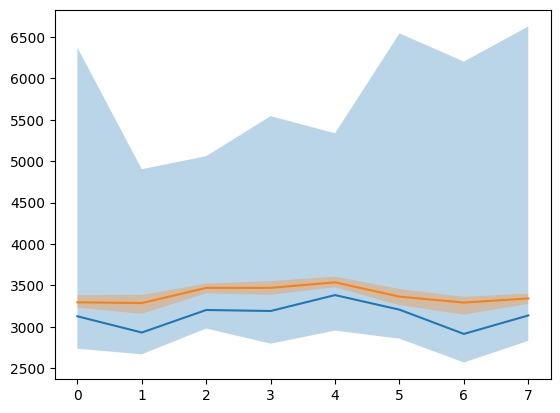

In [19]:
# plt.plot(np.nanmedian(sky_raw_counts, axis=1))
# plt.fill_between(range(len(sky_raw_counts)), np.nanpercentile(sky_raw_counts, 5, axis=1), np.nanpercentile(sky_raw_counts, 95, axis=1), alpha=0.3)

plt.plot(np.nanmedian(sky_darkcal_counts, axis=1))
plt.fill_between(range(len(sky_darkcal_counts)), np.nanpercentile(sky_darkcal_counts, 5, axis=1), np.nanpercentile(sky_darkcal_counts, 95, axis=1), alpha=0.3, label='Dark Calibrated')

plt.plot(np.nanmedian(sky_flatcal_counts, axis=1))
plt.fill_between(range(len(sky_flatcal_counts)), np.nanpercentile(sky_flatcal_counts, 5, axis=1), np.nanpercentile(sky_flatcal_counts, 95, axis=1), alpha=0.3, label='Flat Calibrated')

# plt.plot(np.nanmedian(sky_skysub_counts, axis=1))
# plt.fill_between(range(len(sky_skysub_counts)), np.nanpercentile(sky_skysub_counts, 5, axis=1), np.nanpercentile(sky_skysub_counts, 95, axis=1), alpha=0.3)

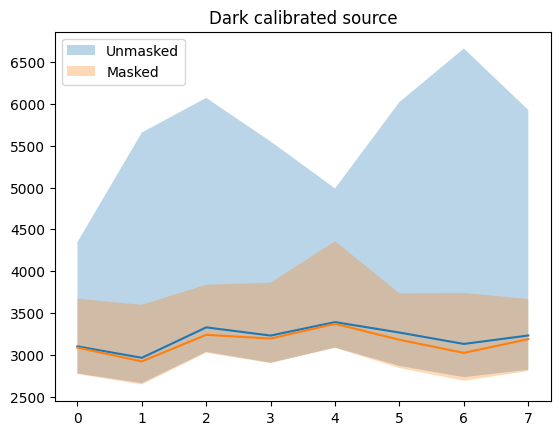

In [20]:
plt.plot(np.nanmedian(src_darkcal_counts, axis=1))
plt.fill_between(range(len(src_darkcal_counts)), np.nanpercentile(src_darkcal_counts, 5, axis=1), np.nanpercentile(src_darkcal_counts, 95, axis=1), alpha=0.3, label='Unmasked')

plt.plot(np.nanmedian(src_darkcal_masked_counts, axis=1))
plt.fill_between(range(len(src_darkcal_masked_counts)), np.nanpercentile(src_darkcal_masked_counts, 5, axis=1), np.nanpercentile(src_darkcal_masked_counts, 95, axis=1), alpha=0.3, label='Masked')
plt.title('Dark calibrated source')
plt.legend()

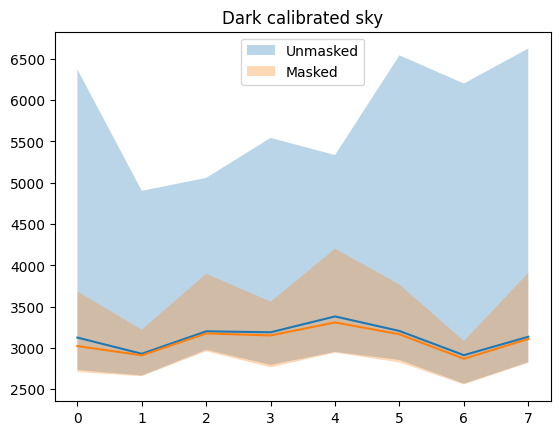

In [21]:
plt.plot(np.nanmedian(sky_darkcal_counts, axis=1))
plt.fill_between(range(len(sky_darkcal_counts)), np.nanpercentile(sky_darkcal_counts, 5, axis=1), np.nanpercentile(sky_darkcal_counts, 95, axis=1), alpha=0.3, label='Unmasked')

plt.plot(np.nanmedian(sky_darkcal_masked_counts, axis=1))
plt.fill_between(range(len(sky_darkcal_masked_counts)), np.nanpercentile(sky_darkcal_masked_counts, 5, axis=1), np.nanpercentile(sky_darkcal_masked_counts, 95, axis=1), alpha=0.3, label='Masked')

plt.title('Dark calibrated sky')
plt.legend()

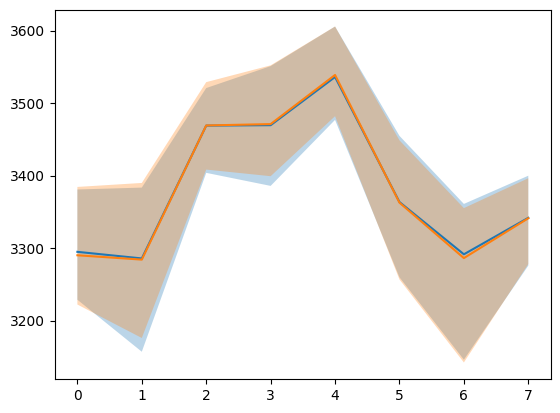

In [22]:
plt.plot(np.nanmedian(sky_flatcal_counts, axis=1))
plt.fill_between(range(len(sky_flatcal_counts)), np.nanpercentile(sky_flatcal_counts, 5, axis=1), np.nanpercentile(sky_flatcal_counts, 95, axis=1), alpha=0.3, label='Unmasked')

plt.plot(np.nanmedian(sky_flatcal_masked_counts, axis=1))
plt.fill_between(range(len(sky_flatcal_masked_counts)), np.nanpercentile(sky_flatcal_masked_counts, 5, axis=1), np.nanpercentile(sky_flatcal_masked_counts, 95, axis=1), alpha=0.3, label='Masked')

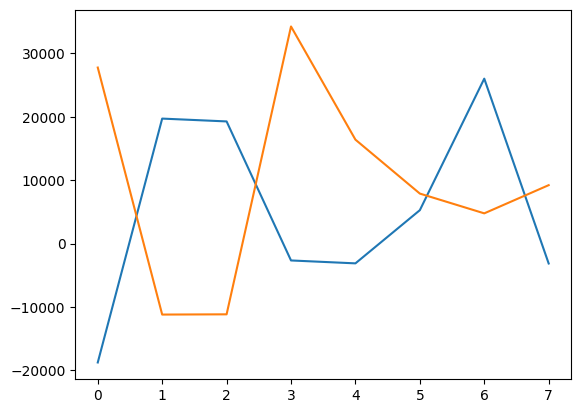

In [23]:
# plot total source counts
plt.plot(np.nansum(src_darkcal_counts, axis=1) - np.nansum(sky_darkcal_counts, axis=1), label='Unmasked')

plt.plot(np.nansum(src_darkcal_masked_counts, axis=1) - np.nansum(sky_darkcal_masked_counts, axis=1), label='Masked')

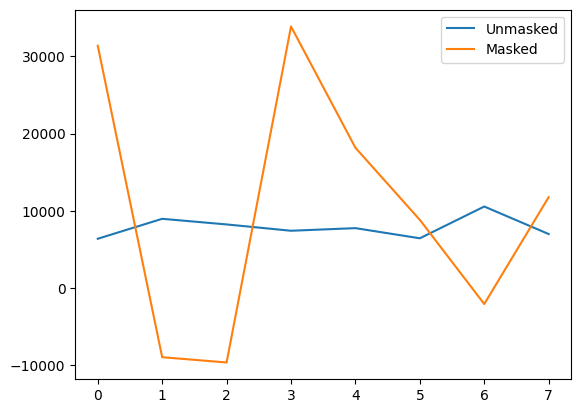

In [24]:
plt.plot(np.nansum(src_flatcal_counts, axis=1) - np.nansum(sky_flatcal_counts, axis=1), label='Unmasked')
plt.plot(np.nansum(src_flatcal_masked_counts, axis=1) - np.nansum(sky_flatcal_masked_counts, axis=1), label='Masked')
plt.legend()

6392.41545846708 15815.411521923048


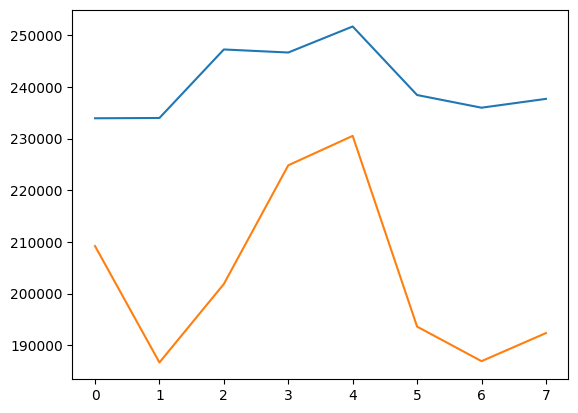

In [25]:
plt.plot(np.nansum(src_flatcal_counts, axis=1), label='Unmasked')
plt.plot(np.nansum(src_flatcal_masked_counts, axis=1), label='Masked')

print(np.nanstd(np.nansum(src_flatcal_counts, axis=1)), np.nanstd(np.nansum(src_flatcal_masked_counts, axis=1)))

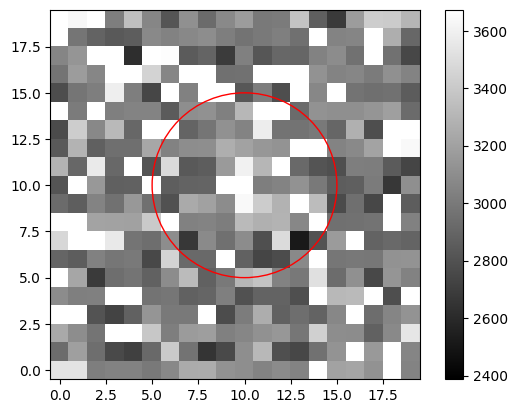

In [26]:
plot_cutouts_around_coordinates(dark_calibrated_list[:1], astrometried_list[:1], src_crd)

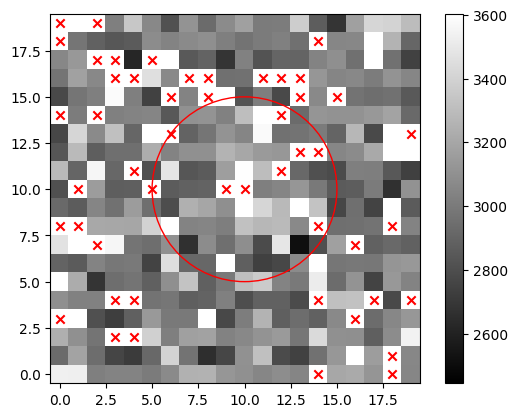

In [27]:
plot_cutouts_around_coordinates(darkcal_masked_list[:1], astrometried_list[:1], src_crd)

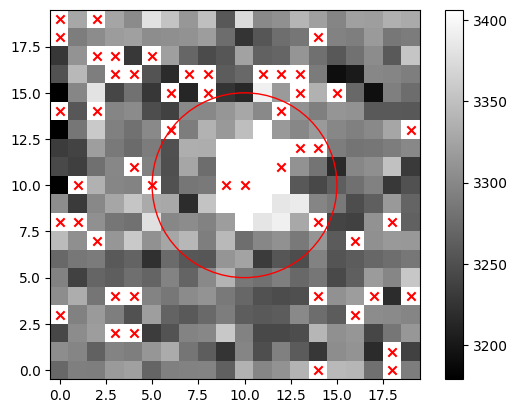

In [28]:
plot_cutouts_around_coordinates(flatcal_masked_list[:1], astrometried_list[:1], src_crd)

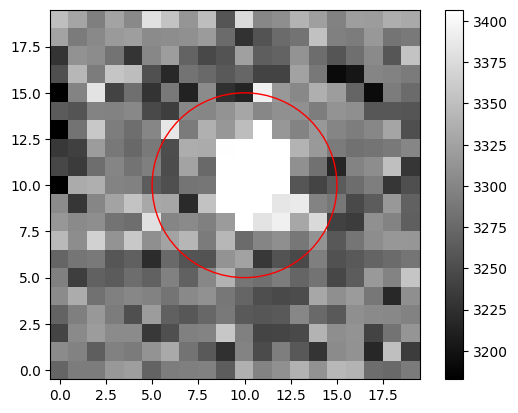

In [46]:
plot_cutouts_around_coordinates(flat_calibrated_list[:1], astrometried_list[:1], src_crd)

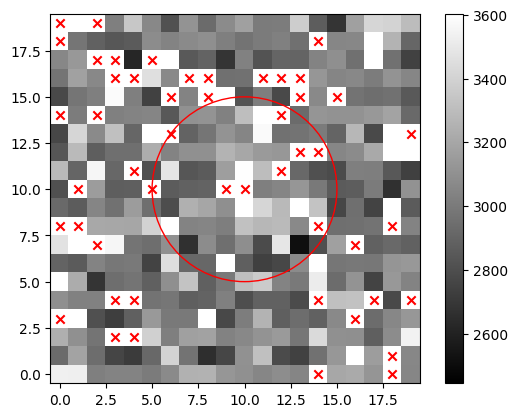

In [47]:
plot_cutouts_around_coordinates(darkcal_masked_list[:1], astrometried_list[:1], src_crd)

In [36]:
lab_flat = fits.getdata('/Users/viraj/winter_data/winter/hackathon_datasets/flats/lab_flats/median_lab_flat_exp_0.06.fits')

In [37]:
sky_lab_flat_cutout = get_cutout_around_coordinate(lab_flat, WCS(fits.getheader(astrometried_list[0])), sky_crd)
sky_darkcal_cutout = get_cutout_around_coordinate(fits.getdata(darkcal_masked_list[0]), WCS(fits.getheader(astrometried_list[0])), sky_crd)
sky_darkcal_masked_cutout = get_cutout_around_coordinate(fits.getdata(darkcal_masked_list[0]), WCS(fits.getheader(astrometried_list[0])), sky_crd)

<Axes: >

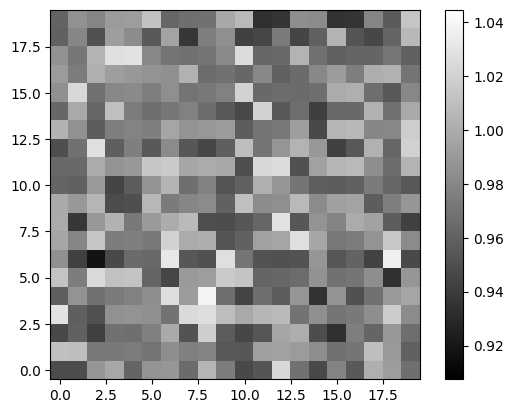

In [38]:
plot_image(sky_lab_flat_cutout)

<Axes: >

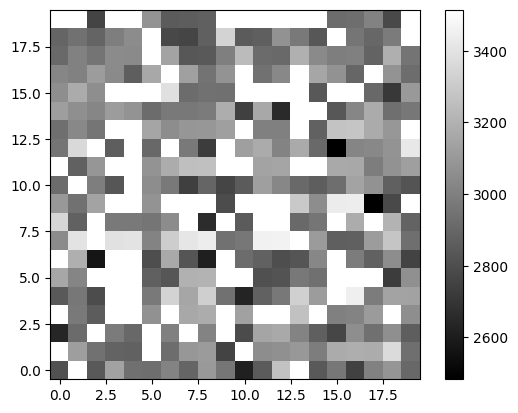

In [39]:
plot_image(sky_darkcal_cutout)

<Axes: >

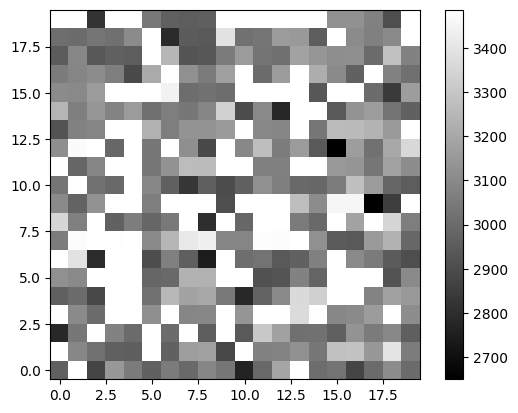

In [52]:
plot_image(sky_darkcal_cutout/sky_lab_flat_cutout)

<Axes: >

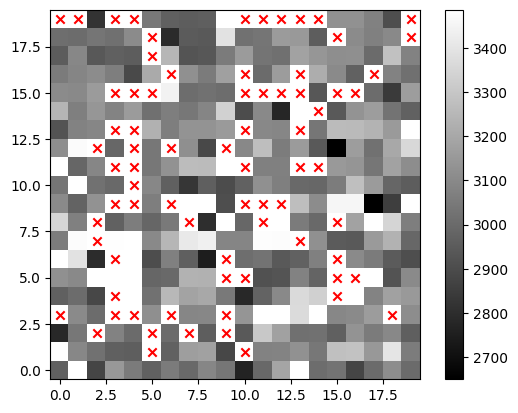

In [55]:
plot_image(sky_darkcal_masked_cutout/sky_lab_flat_cutout, flag_nans=True)

In [79]:
# Get darkcal counts for bad pixel masks
bad_pixel_mask = fits.getdata('/Users/viraj/winter_data/winter/hackathon_datasets/bad_pixel_masks/v0.1/bad_pixel_mask_J_4.fits')

# select 100 bad pixels where bad_pixel_mask == 1
bad_pixel_coords = np.where(bad_pixel_mask == 1)
bad_pixel_coords = np.array(bad_pixel_coords).T

counts_list = []
for filename in dark_calibrated_list:
    data = fits.getdata(filename)
    # add 100 random bad pixels
    bad_pixel_data = data[bad_pixel_coords[:, 0], bad_pixel_coords[:, 1]]
    counts_list.append(bad_pixel_data)

In [80]:
bad_pixel_counts = np.array(counts_list)

In [81]:
# choose pixels within center of the image

In [82]:
center = np.array([1000, 512])
half_size = 100
x, y = np.indices(bad_pixel_mask.shape)
x = x[center[0]-half_size:center[0]+half_size, center[1]-half_size:center[1]+half_size]
y = y[center[0]-half_size:center[0]+half_size, center[1]-half_size:center[1]+half_size]
x = x.flatten()
y = y.flatten()


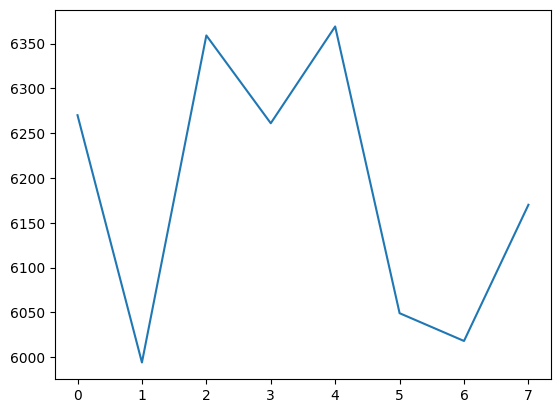

In [83]:
plt.plot(bad_pixel_counts[:, 600])

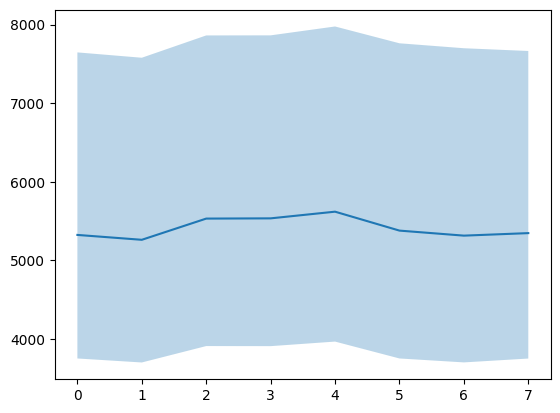

In [84]:
plt.plot(np.nanmedian(bad_pixel_counts, axis=1))
plt.fill_between(range(len(bad_pixel_counts)), np.nanpercentile(bad_pixel_counts, 5, axis=1), np.nanpercentile(bad_pixel_counts, 95, axis=1), alpha=0.3)

In [40]:
lab_flat_bad_counts = []
bad_data = lab_flat[bad_pixel_coords[:, 0], bad_pixel_coords[:, 1]]

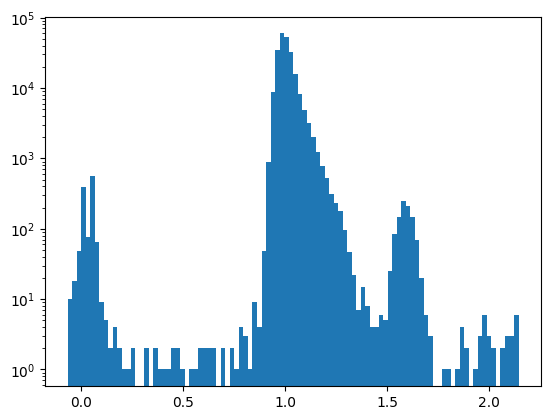

In [99]:
plt.hist(bad_data, bins=100)
plt.yscale('log')

In [102]:
# nightly flat
calibration_flat = fits.getdata(target_dir.joinpath('calibration_flats/flat__689f73f52db5b6196d425630fd5b85abcedb0b4c.fits'))
bad_pixel_flatvals = calibration_flat[bad_pixel_coords[:, 0], bad_pixel_coords[:, 1]]

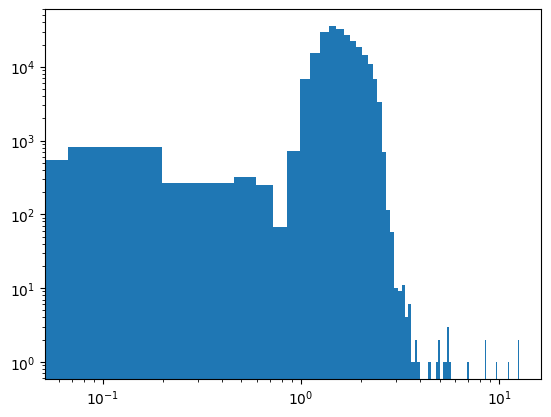

In [103]:
plt.hist(bad_pixel_flatvals, bins=100)
plt.yscale('log')
plt.xscale('log')

In [50]:
def get_outlier_pixels(data, thresh=2.0):
    """
    Get outlier pixels from a list of images.
    """
    data = np.array(data)
    med = np.nanmedian(data, axis=0)
    std = np.nanstd(data, axis=0)
    outliers = np.abs(data - med) > thresh*std
    return outliers

In [58]:
filelist = glob('/Users/viraj/Downloads/WINTERcamera_20250221-07*.fits')
outlier_mask = np.ones_like(fits.getdata(filelist[0]), dtype=bool)
for filename in filelist:
    data = fits.getdata(filename)
    outliers = get_outlier_pixels(data, thresh=2.0)
    outlier_mask = outlier_mask & outliers


In [59]:
write_image(outlier_mask.astype(int), filename='/Users/viraj/Downloads/outliers.fits', header=fits.getheader(filelist[0]))

<Axes: >

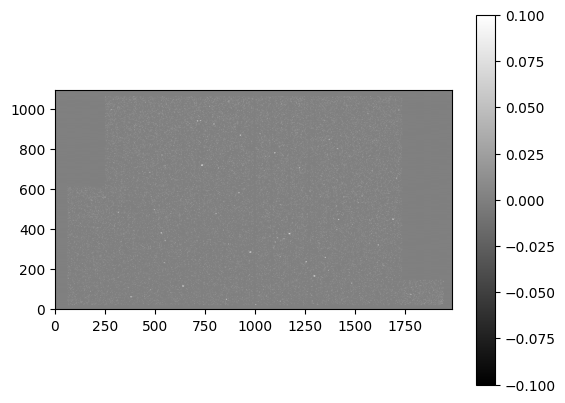

In [53]:
plot_image(outliers)

In [60]:
new_bad_pixel_coords = np.where(outlier_mask == 1)

In [61]:
new_bad_pixel_flatvals = calibration_flat[new_bad_pixel_coords[0], new_bad_pixel_coords[1]]

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 2.000e+01, 2.700e+01,
        8.600e+01, 1.650e+02, 2.650e+02, 3.580e+02, 4.250e+02, 5.100e+02,
        5.590e+02, 6.330e+02, 6.870e+02, 8.120e+02, 9.790e+02, 1.065e+03,
        1.254e+03, 1.356e+03, 1.440e+03, 1.495e+03, 1.610e+03, 1.579e+03,
        1.456e+03, 1.515e+03, 1.253e+03, 1.192e+03, 1.049e+03, 9.120e+02,
        8.320e+02, 6.770e+02, 6.150e+02, 4.870e+02, 3.970e+02, 2.980e+02,
        2.620e+02, 2.050e+02, 1.640e+02, 1.360e+02, 1.320e+02, 9.200e+01,
        9.900e+01, 8.100e+01, 6.400e+01, 6.100e+01, 5.600e+01, 3.500e+01,
        3.600e+01, 2.200e+01, 2.500e+01, 2.800e+01, 2.300e+01, 7.000e+00,
        1.800e+01, 3.000e+00, 9.000e+00, 3.000e+00, 8.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 3.000e+0

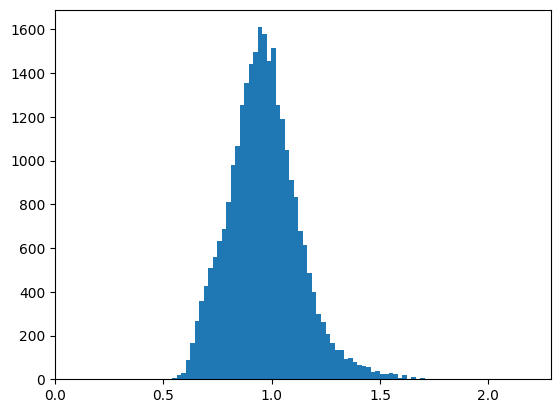

In [62]:
plt.hist(new_bad_pixel_flatvals, bins=100)

In [92]:
all_bad_pixel_mask = bad_pixel_mask | outlier_mask
good_pixel_coords = np.where(all_bad_pixel_mask == 0)
good_pixel_flatvals = calibration_flat[good_pixel_coords[0], good_pixel_coords[1]]


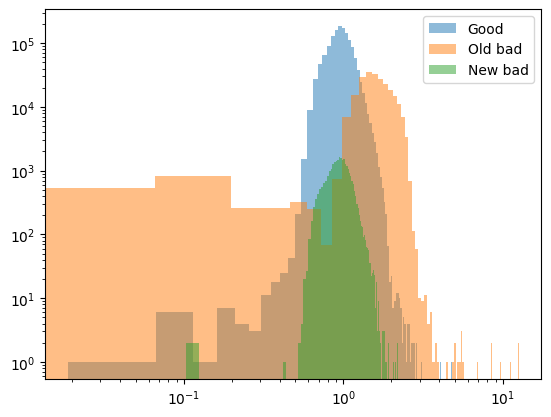

In [107]:
_ = plt.hist(good_pixel_flatvals, bins=100, alpha=0.5, label='Good')
_ = plt.hist(bad_pixel_flatvals, bins=100, alpha=0.5, label='Old bad')
_ = plt.hist(new_bad_pixel_flatvals, bins=100, alpha=0.5, label='New bad')

plt.legend()
plt.yscale('log')
plt.xscale('log')

In [108]:
len(new_bad_pixel_coords[0])/bad_pixel_coords.shape[0]

0.12059581531472502

In [111]:
new_badpixel_counts_list = []
good_pixel_counts_list = []
new_counts_list = []

for filename in dark_calibrated_list:
    data = fits.getdata(filename)
    # add 100 random bad pixels
    new_bad_pixel_data = data[new_bad_pixel_coords[0], new_bad_pixel_coords[1]]
    new_counts_list.append(new_bad_pixel_data)
    good_pixel_counts_list.append(data[good_pixel_coords[0], good_pixel_coords[1]])


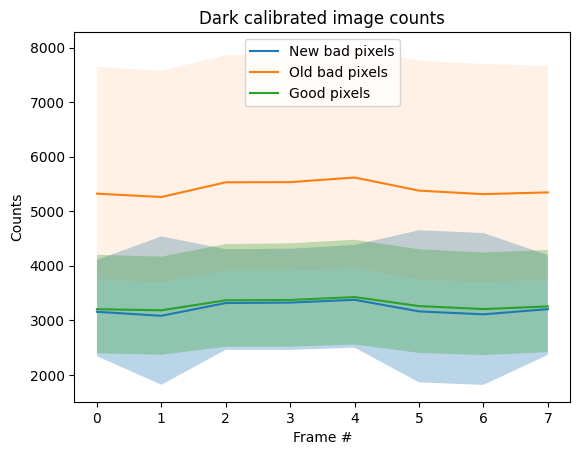

In [121]:
plt.plot(np.nanmedian(new_counts_list, axis=1), label='New bad pixels')
plt.fill_between(range(len(new_counts_list)), np.nanpercentile(new_counts_list, 5, axis=1), np.nanpercentile(new_counts_list, 95, axis=1), alpha=0.3)

plt.plot(np.nanmedian(bad_pixel_counts, axis=1), label='Old bad pixels')
plt.fill_between(range(len(bad_pixel_counts)), np.nanpercentile(bad_pixel_counts, 5, axis=1), np.nanpercentile(bad_pixel_counts, 95, axis=1), alpha=0.1)

plt.plot(np.nanmedian(good_pixel_counts_list, axis=1), label='Good pixels')
plt.fill_between(range(len(good_pixel_counts_list)), np.nanpercentile(good_pixel_counts_list, 5, axis=1), np.nanpercentile(good_pixel_counts_list, 95, axis=1), alpha=0.3)

plt.legend(fontsize=10)
plt.ylabel(r'Counts')
plt.xlabel(r'Frame #')
plt.title('Dark calibrated image counts')
plt.savefig(r'../bad_pixel_counts.pdf', bbox_inches='tight')


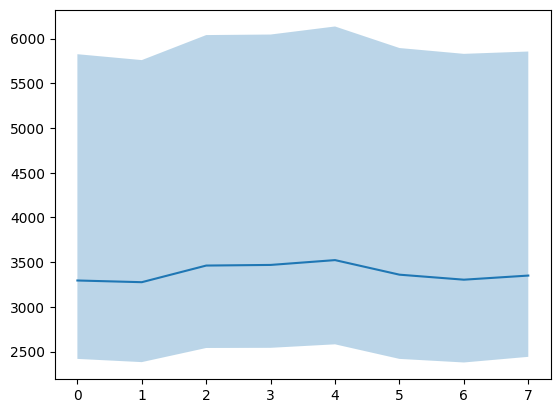

In [110]:
plt.plot()
plt.fill_between(range(len(darkcal_med_counts)), darkcal_5perc_counts, darkcal_95perc_counts, alpha=0.3)